In [151]:
# Reload the Jupyter notebook kernel
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2

import numpy as np
import sys
import os
import traceback
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import matlab.engine
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop

mateng = None

In [152]:
import dataset_preparation
import deep_learning_models

importlib.reload(dataset_preparation)
importlib.reload(deep_learning_models)

from dataset_preparation import awgn, LoadDataset, ChannelIndSpectrogram
from deep_learning_models import NPairNet, identity_loss

In [153]:
def load_matlab(session_id, mateng):
    if mateng:
        mateng.quit()
    mateng = matlab.engine.connect_matlab(session_id)
    mateng.cd('/home/smazokha2016/Desktop/mobintel-rffi/fingerprinting/lora_rffi_working', nargout=0)

def train_feature_extractor(data, label, dev_range, batch_size=32, patience=20, row=50, col=14, loss_type='n_loss', alpha=0.5, num_neg=1, npair_type='samedev'):
    ChannelIndSpectrogramObj = ChannelIndSpectrogram()
    
    # Convert time-domain IQ samples to channel-independent spectrograms.
    data = ChannelIndSpectrogramObj.channel_ind_spectrogram(data, row, col)
    
    NPairNetObj = NPairNet()
    
    # Create an RFF extractor.
    feature_extractor = NPairNetObj.feature_extractor(data.shape)
    
    # Create the Triplet net using the RFF extractor.
    npair_net = NPairNetObj.create_npair_net(feature_extractor, alpha, num_neg, loss_type)

    # Create callbacks during training
    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta = 0, patience = patience, restore_best_weights=True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = patience, min_lr=1e-6, verbose=1)]
    
    # Split the dasetset into validation and training sets.
    data_train, data_valid, label_train, label_valid = train_test_split(data, label, test_size=0.1, shuffle= True)
    del data, label
    
    # Create the trainining generator.
    train_generator = NPairNetObj.create_generator(batch_size, dev_range,  data_train, label_train, npair_type)
    # Create the validation generator.
    valid_generator = NPairNetObj.create_generator(batch_size, dev_range, data_valid, label_valid, npair_type)
    
    # Use the RMSprop optimizer for training.
    opt = RMSprop(learning_rate=1e-3)
    npair_net.compile(loss = identity_loss, optimizer = opt)

    # Start training.
    history = npair_net.fit(train_generator,
                              steps_per_epoch = data_train.shape[0]//batch_size,
                              epochs = 1000,
                              validation_data = valid_generator,
                              validation_steps = data_valid.shape[0]//batch_size,
                              verbose=1, 
                              callbacks = callbacks)

    return feature_extractor, history

def evaluate(true_label, pred_label, classes):
    conf_mat = confusion_matrix(true_label, pred_label, normalize='true')
    # classes = np.arange(0, 10, dtype = int) + 1

    plt.figure()
    sns.heatmap(conf_mat, annot=True, 
                cmap='Blues',
                cbar = False,
                xticklabels=classes, 
                yticklabels=classes)
    plt.xlabel('Predicted label', fontsize = 20)
    plt.ylabel('True label', fontsize = 20)
    plt.show()

def get_dataset_devices(labels, show=False):
    # Retrives a list of node IDs from a given array of nodes (sorted)
    devices = list(set(labels.flatten()))
    devices.sort()

    if show: print(devices)

    return devices

def load_dataset_info(dataset_name, rx_name):
    # Available dataset names:
    # - v1_jul_13 - 25 Msps, 2-hour period, manual capture, only one RX node (node1-1)
    # - v2_jul_19 - 25 Msps, 24-hour period, automated capture, 4 RX nodes
    # - v2_jul_21 - 20 Msps, 4-hour period, automated capture, 4 RX nodes

    # Available rx names:
    # - node1-1
    # - node1-20
    # - node20-1
    # - node19-19

    root_path_v1 = '/home/smazokha2016/Desktop/orbit_dataset_v1'
    root_path_v2_jul19 = '/home/smazokha2016/Desktop/mobintel-orbit-dataset_h5'
    root_path_v2_jul21 = '/home/smazokha2016/Desktop/orbit_dataset_v2_jul21'

    if dataset_name == 'v1_jul_13':
        dataset_train_path = os.path.join(root_path_v1, 'training_2024-07-13_06-53-20', rx_name + '_non_eq_train.h5')
        model_path = os.path.join(root_path_v1, 'my_models')
        dataset_epoch_paths = [os.path.join(root_path_v1, f, rx_name + '_non_eq_test.h5') for f in os.listdir(root_path_v1) if f.startswith('epoch_')]
        samp_rate = 25e6
    elif dataset_name == 'v2_jul_19':
        dataset_train_path = os.path.join(root_path_v2_jul19, rx_name + '_training_2024-07-20_00-50-38.h5')
        dataset_epoch_path = os.path.join(root_path_v2_jul19, rx_name + '_epoch_2024-07-20_01-15-26.h5')
        model_path = os.path.join(root_path_v2_jul19, 'my_models', 'orbit_v1_aug.h5')
        dataset_epoch_paths = [os.path.join(root_path_v2_jul19, f) for f in os.listdir(root_path_v2_jul19) if f.startswith(rx_name + '_epoch')]
        samp_rate = 25e6
    elif dataset_name == 'v2_jul_21':
        dataset_train_path = os.path.join(root_path_v2_jul21, rx_name + '_training_2024-07-21_14-49-09.h5')
        dataset_epoch_path = os.path.join(root_path_v2_jul21, rx_name + '_epoch_2024-07-21_16-02-04.h5')
        model_path = os.path.join(root_path_v2_jul21, 'my_models')
        dataset_epoch_paths = [os.path.join(root_path_v2_jul21, f) for f in os.listdir(root_path_v2_jul21) if f.startswith(rx_name + '_epoch')]
        samp_rate = 20e6
    else: print('Invalid dataset name.')

    node_ids_train = get_dataset_devices(LoadDataset().load_iq_samples(dataset_train_path)[1], show=False)
    node_ids_epoch = get_dataset_devices(LoadDataset().load_iq_samples(dataset_epoch_path)[1], show=False)

    return dataset_train_path, dataset_epoch_paths, model_path, node_ids_train, node_ids_epoch, samp_rate

def filter_dataset(data, label, rssi, dev_range, pkt_range):
    # If the list of devices isn't specified - loop through all of the available ones
    if dev_range is None:
        dev_range = set(label.flatten())

    # Filter indexes of frames to keep based on dev_range
    frame_idx_filtered = []
    for dev_idx in dev_range:
        # Extract only the specified devices, and for each only pkt_range frames
        frame_idx_device = np.where(label==int(dev_idx))[0][pkt_range]
        frame_idx_filtered.extend(frame_idx_device)
    
    # Filter the dataset based on dev_range and pkt_range
    label = label[frame_idx_filtered]
    rssi = rssi[frame_idx_filtered]
    data = data[frame_idx_filtered, :]

    return data, label, rssi

def rssi_to_weight(rssi_dbm):
    # Convert RSSI to weighting factor by normalizing between [0, 1]
    # Note: weak signal is below 90 dBm, very strong signal is above -10 dBm
    if rssi_dbm < -100: 
        print(f'RSSI: {rssi_dbm}. Adjust normalization!')

    rssi_bounds = [-100, 0]
    rssi_scaled = (rssi_dbm - rssi_bounds[0]) / (rssi_bounds[1] - rssi_bounds[0])

    return rssi_scaled

def evaluate_fingerprint_similarity_all(dev_range, fingerprints_all, rssis_all, ref_device_idx, ref_epoch_idx, epoch_count, show_heatmap = False):
    # Extract reference FPs for each RX device
    ref_fps = []
    for rx_i in np.arange(len(fingerprints_all)):
        ref_fps.append(fingerprints_all[rx_i][ref_device_idx, ref_epoch_idx, :, :])
    
    # Initialize a matrix to store average distances with respect to reference fingerprints
    avg_distances = np.zeros((len(dev_range), epoch_count))

    # Compute average Euclidean distance with respect to reference fingerprints for each device and epoch
    for i in np.arange(avg_distances.shape[0]):
        for j in np.arange(avg_distances.shape[1]):
            rx_distances = []
            rx_weights = []
            for rx_i in np.arange(len(fingerprints_all)):
                # Extract the K fingerprints for device i at epoch j
                data = fingerprints_all[rx_i][i, j, :, :]

                # Compute the Euclidean distances between reference fingerprints and current fingerprints
                distances = cdist(ref_fps[rx_i], data, 'euclidean')

                # Extract the K RSSI values for device i at epoch j and compute an average value
                rssis = rssis_all[rx_i][i, j, :]

                rx_distances.append(np.mean(distances))
                rx_weights.append(rssi_to_weight(np.mean(rssis)))

            # rx_weights = [0.5, 0.5, 0.5, 0.5]
            
            avg_distances[i, j] = np.sum(d * w for d, w in zip(rx_distances, rx_weights))/len(rx_weights)

    device_distances = np.mean(avg_distances, axis=1)

    if show_heatmap:
        # Plot the heatmaps side by side
        _, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Plot the heatmap
        sns.heatmap(avg_distances, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Average Euclidean Distance with Respect to Reference'}, yticklabels=dev_range, ax=axes[0])
        axes[0].set_title(f'Average Euclidean Distance of Fingerprints Across Devices and Epochs\n(Reference: device={dev_range[ref_device_idx]}, epoch={ref_epoch_idx})')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Device')

        # Plot the bar chart
        axes[1].bar(np.arange(avg_distances.shape[0]), device_distances)
        axes[1].set_title(f"Device fingerprint comparison\n(Reference: device={dev_range[ref_device_idx]}, epoch={ref_epoch_idx+1})")
        axes[1].set_xlabel('Device')
        axes[1].set_ylabel('Average Distance')

    device_distances.sort()

    return device_distances[0], device_distances[1]
        
def evaluate_fingerprint_similarity(dev_range, fingerprints, ref_device_idx, ref_epoch_idx, show_heatmap = False):
    N, M, K, D = fingerprints.shape

    # Extract reference fingerprints at device_idx and epoch_idx
    reference_fingerprints = fingerprints[ref_device_idx, ref_epoch_idx, :, :]

    # Initialize a matrix to store average distances with respect to reference fingerprints
    avg_distances = np.zeros((N, M))

    # Compute average Euclidean distance with respect to reference fingerprints for each device and epoch
    for i in range(N):
        for j in range(M):
            # Extract the K fingerprints for device i at epoch j
            data = fingerprints[i, j, :, :]
            # Compute the Euclidean distances between reference fingerprints and current fingerprints
            distances = cdist(reference_fingerprints, data, 'euclidean')
            # Average the distances
            avg_distance = np.mean(distances)
            avg_distances[i, j] = avg_distance

    device_distances = np.mean(avg_distances, axis=1)

    if show_heatmap:
        # Plot the heatmaps side by side
        _, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Plot the heatmap
        sns.heatmap(avg_distances, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Average Euclidean Distance with Respect to Reference'}, yticklabels=dev_range, ax=axes[0])
        axes[0].set_title(f'Average Euclidean Distance of Fingerprints Across Devices and Epochs\n(Reference: device={dev_range[ref_device_idx]}, epoch={ref_epoch_idx})')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Device')

        # Plot the bar chart
        axes[1].bar(np.arange(avg_distances.shape[0]), device_distances)
        axes[1].set_title(f"Device fingerprint comparison\n(Reference: device={dev_range[ref_device_idx]}, epoch={ref_epoch_idx+1})")
        axes[1].set_xlabel('Device')
        axes[1].set_ylabel('Average Distance')

    device_distances.sort()

    return device_distances[0], device_distances[1]

In [154]:
def merge_frames(data, label, dev_count, n):
    if n < 1:
        raise Exception('n needs to be >=1')
    elif n == 1:
        return data, label
    
    allframe_count = data.shape[0]
    devframe_count = int(allframe_count/dev_count)
    devframe_count_new = int(devframe_count / n)
    sample_count = data.shape[1]
    sample_count_new = sample_count * n

    data_reshaped = data.reshape(dev_count, devframe_count, sample_count)

    data_reshaped_merged = np.zeros((dev_count, devframe_count_new, sample_count_new), dtype=data.dtype)
    for dev_i in np.arange(0, dev_count):
        for frame_i in np.arange(0, devframe_count_new):
            for i in np.arange(n):
                offset = sample_count * i
                samp_start = 0 + offset
                samp_end = sample_count + offset
                data_reshaped_merged[dev_i, frame_i, samp_start:samp_end] = data_reshaped[dev_i, frame_i * n + i, :]

    data = data_reshaped_merged.reshape(dev_count * devframe_count_new, sample_count_new)
    
    label = label[0::n]

    return data, label

def run_training(mateng, data_config, model_config, aug_config, aug_on):
    # Retrieve information about the dataset: paths to dataset files, node IDs, sampling rate
    dataset_train_path, _, model_path, node_ids_train, _, samp_rate = load_dataset_info(data_config['dataset_name'], data_config['rx_name'])

    # Retrieve (and optionally augment) the data to produce data, label variables
    if aug_on:
        # Note: before loading, ensure that there's a MATLAB session named 'mobintel_aug' (or update the name).
        #       To launch a session, run the following:
        #       - source ~/.bash_profile (or similar)
        #       - matlab -nodesktop -r "matlab.engine.shareEngine('mobintel_aug')"
        #       The system will either share a session with this name, or will say that such name is already used
        #       and instead will suggest an alternative name.
        result = mateng.augmentation(dataset_train_path, samp_rate, aug_config['t_rms_bounds'], aug_config['d_f_bounds'], aug_config['k_factor_bounds'], aug_config['multiplier'])
        data = np.array(result['data_aug']).swapaxes(0, 1)
        label = np.array(result['label_aug']).swapaxes(0, 1)
        rssi = np.array(result['rssi_aug']).swapaxes(0, 1)
    else:
        data, label, rssi = LoadDataset().load_iq_samples(dataset_train_path)

    # Filter the dataset (pick specified nodes & frames)
    data, label, _ = filter_dataset(data, label, rssi, node_ids_train, np.arange(0, data_config['frame_count_train']))

    # Merge N consecutive frames to increase model input size (and increase time-domain impact)
    # data, label = merge_frames(data, label, len(node_ids_train), data_config['merge_factor'])

    # Filter the dataset (pick only a specified number of frames)
    data = data[:, 0:data_config['samples_count']]

    # Shuffle the order of frames/labels
    data, label = LoadDataset().shuffle(data, label)

    # Add AWGN
    # data = awgn(data, np.arange(aug_config['awgn'][0][0], aug_config['awgn'][0][1]))

    # Train the model
    feature_extractor, history = train_feature_extractor(data, label, 
                                                   node_ids_train, 
                                                   batch_size=model_config['batch_size'], 
                                                   patience=model_config['patience'], 
                                                   row=model_config['row'], 
                                                   col=model_config['col'],
                                                   loss_type=model_config['loss_type'],
                                                   alpha=model_config['alpha'],
                                                   num_neg=model_config['loss_num_neg'],
                                                   npair_type=model_config['npair_type'])

    # Save the model
    feature_extractor.save(model_path)

    return feature_extractor, history

def produce_fingerprints(feature_extractor, data_config, model_config, node_ids_epoch):
    # Retrieve information about the dataset: paths to dataset files, node IDs, sampling rate
    _, dataset_epoch_paths, model_path, _, _, samp_rate = load_dataset_info(data_config['dataset_name'], data_config['rx_name'])

    # Load the model from the file if not available
    if not feature_extractor:
        feature_extractor = load_model(model_path, compile=False)

    fingerprints = np.zeros(shape=(len(node_ids_epoch), len(dataset_epoch_paths), data_config['frame_count_epoch'], model_config['fp_len']))
    rssis = np.zeros(shape=(len(node_ids_epoch), len(dataset_epoch_paths), data_config['frame_count_epoch']))

    # Extract fingerprint for every epoch
    for m in np.arange(len(dataset_epoch_paths)):
        label = []
        try:
            print('.', end='')

            # Load all frames/samples for a given epoch
            data, label, rssi = LoadDataset().load_iq_samples(dataset_epoch_paths[m])

            # Filter the dataset (pick specified nodes & frames)
            data, label, rssi = filter_dataset(data, label, rssi, node_ids_epoch, np.arange(0, data_config['frame_count_epoch']))

            # data, label = merge_frames(data, label, len(node_ids_epoch), data_config['merge_factor'])

            # Filter the dataset (pick only a specified number of frames)
            data = data[:, 0:data_config['samples_count']]

            # Add AWGN
            # data = awgn(data, np.arange(aug_config['awgn'][0][0], aug_config['awgn'][0][1]))

            # Prepare input data for the model (convert to spectrogram images)
            data_freq = ChannelIndSpectrogram().channel_ind_spectrogram(data, model_config['row'], model_config['col'])

            # Extract fingerprints from the trained model
            data_fps = feature_extractor.predict(data_freq)

            # Reshape the fingerprints for easier retrieval
            data_fps_reshaped = data_fps.reshape(len(node_ids_epoch), int(data.shape[0]/len(node_ids_epoch)), data_fps.shape[1])
            rssi_reshaped = rssi.reshape(len(node_ids_epoch), int(data.shape[0]/len(node_ids_epoch)))

            # Save fingerprints for further analysis
            for n in np.arange(data_fps_reshaped.shape[0]):
                for k in np.arange(data_fps_reshaped.shape[1]):
                    fingerprints[n, m, k, :] = data_fps_reshaped[n, k, :]
                    rssis[n, m, k] = rssi_reshaped[n, k]
        except Exception as e:
            get_dataset_devices(label, show=True)
            print(e)
            traceback.print_exc()

    return samp_rate, fingerprints, rssis

def run_fingerprinting_single(feature_extractor, data_config, model_config, node_ids_epoch, aug_on, show_fp_heatmaps):
    # Produce fingerprints
    samp_rate, fingerprints, _ = produce_fingerprints(feature_extractor, data_config, model_config, node_ids_epoch)

    # Evaluate similarity of fingerprints
    fp_distances = np.zeros((len(node_ids_epoch), 2))
    for device_idx in np.arange(len(node_ids_epoch)):
        top1_dist, top2_dist = evaluate_fingerprint_similarity(node_ids_epoch, fingerprints, device_idx, ref_epoch_idx=0, show_heatmap=show_fp_heatmaps)
        fp_distances[device_idx, 0] = top1_dist
        fp_distances[device_idx, 1] = top2_dist

    # Prepare title for the plot
    fp_discrimination_figure_title = f"Dataset: {data_config['dataset_name']}, RX: {data_config['rx_name']}, Frames: [{data_config['frame_count_train']}/{data_config['frame_count_epoch']}], Samples: [{data_config['samples_count']} ({int(samp_rate/1e6)} MHz)], Augmentation: {aug_on}, Alpha: {model_config['alpha']}"

    return fp_distances, fp_discrimination_figure_title

def run_fingerprinting_all(rx_nodes, models, experiment_configs, node_ids_epoch, aug_on, show_fp_heatmaps):
    # Produce fingerprints for all receivers, using corresponding models
    min_epoch_count = sys.maxint
    fingerprints_all = []
    rssis_all = []
    for i, rx_node in enumerate(rx_nodes):
        print(f"Generating eval finerprints for {rx_node}...")
        data_config, _, model_config = experiment_configs[i]
        # Samp rate is always the same, so we'll just use the last one
        samp_rate, fingerprints, rssis = produce_fingerprints(models[i], data_config, model_config, node_ids_epoch)
        fingerprints_all.append(fingerprints)
        rssis_all.append(rssis)

        min_epoch_count = min(min_epoch_count, fingerprints.shape[1])
        
    # Evaluate similarity of fingerprints
    fp_distances = np.zeros((len(node_ids_epoch), 2))
    for device_idx in np.arange(len(node_ids_epoch)):
        top1_dist, top2_dist = evaluate_fingerprint_similarity_all(node_ids_epoch, fingerprints_all, rssis_all, device_idx, ref_epoch_idx=0, epoch_count=min_epoch_count, show_heatmap = show_fp_heatmaps)
        fp_distances[device_idx, 0] = top1_dist
        fp_distances[device_idx, 1] = top2_dist

    # Prepare title for the plot (all settings are taken from the last device's config for now, since they're all almost the same)
    fp_discrimination_figure_title = f"Dataset: {data_config['dataset_name']}, RX: ALL, Frames: [{data_config['frame_count_train']}/{data_config['frame_count_epoch']}], Samples: [{data_config['samples_count']} ({int(samp_rate/1e6)} MHz)], Augmentation: {aug_on}, Alpha: {model_config['alpha']}"

    return fp_distances, fp_discrimination_figure_title # TODO: replace None by variable


Generating eval finerprints for node1-1...
3/3 [==============================] - 0s 3ms/step
Generating eval finerprints for node1-20...
3/3 [==============================] - 0s 2ms/step
Generating eval finerprints for node20-1...
3/3 [==============================] - 0s 2ms/step
Generating eval finerprints for node19-19...
3/3 [==============================] - 0s 2ms/step


/tmp/ipykernel_257211/3140263893.py:172: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  avg_distances[i, j] = np.sum(d * w for d, w in zip(rx_distances, rx_weights))/len(rx_weights)
/tmp/ipykernel_257211/3140263893.py:172: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  avg_distances[i, j] = np.sum(d * w for d, w in zip(rx_distances, rx_weights))/len(rx_weights)
/tmp/ipykernel_257211/3140263893.py:172: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  avg_distances[i, j] = np.sum(d * w for d, w in zip(rx_distances, rx_weights))/len(rx_weights)
/tmp/ipykernel_257211/3140263893.py:172: Deprecation

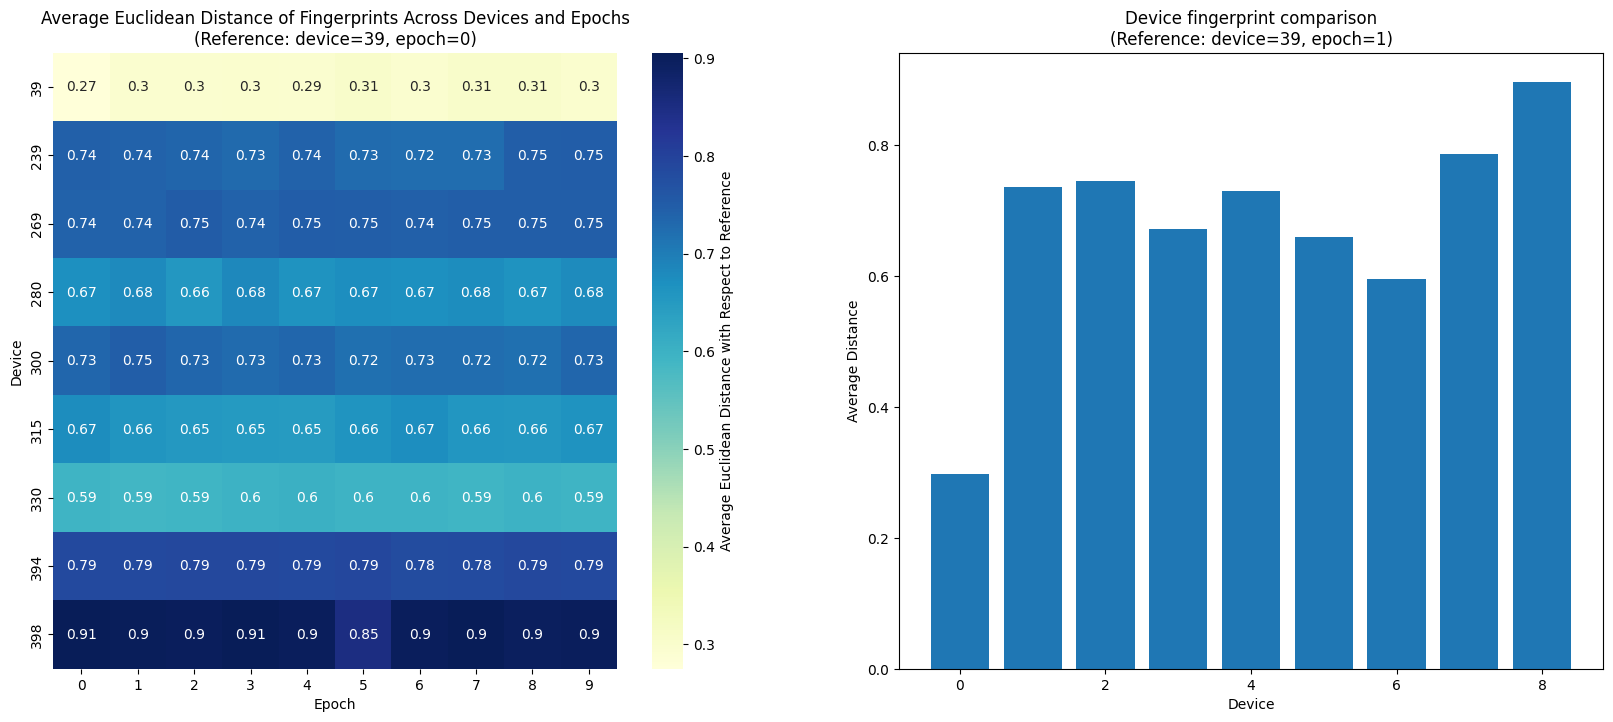

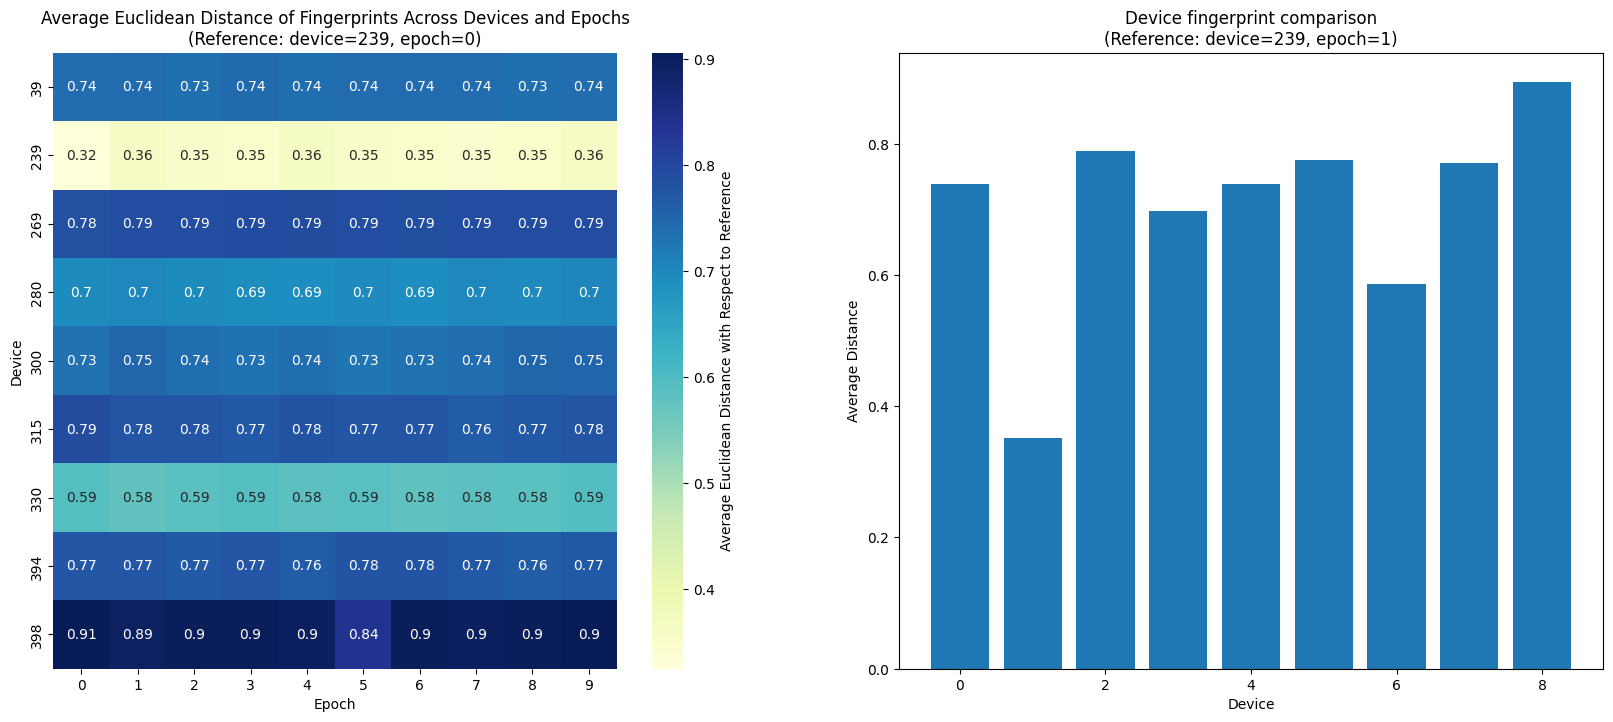

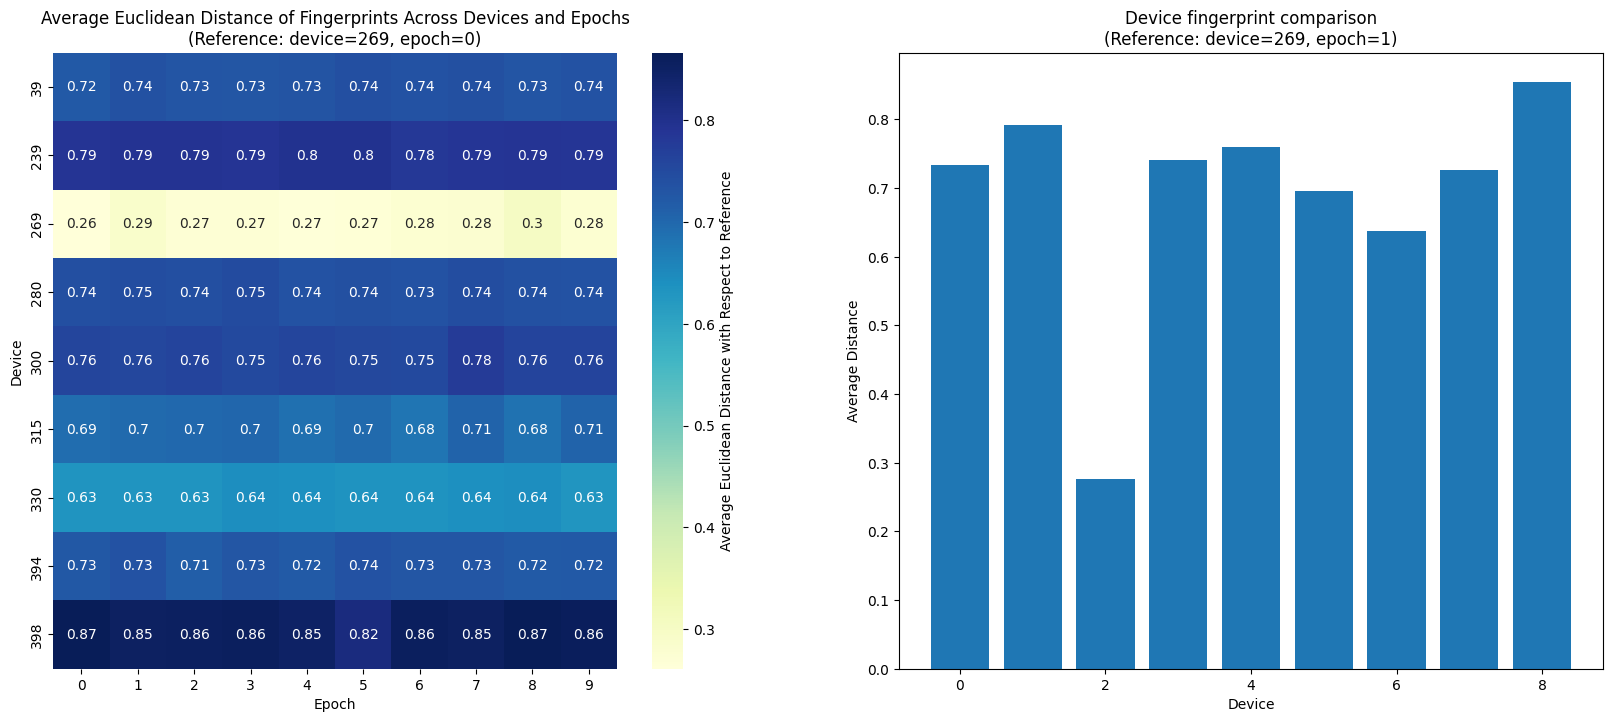

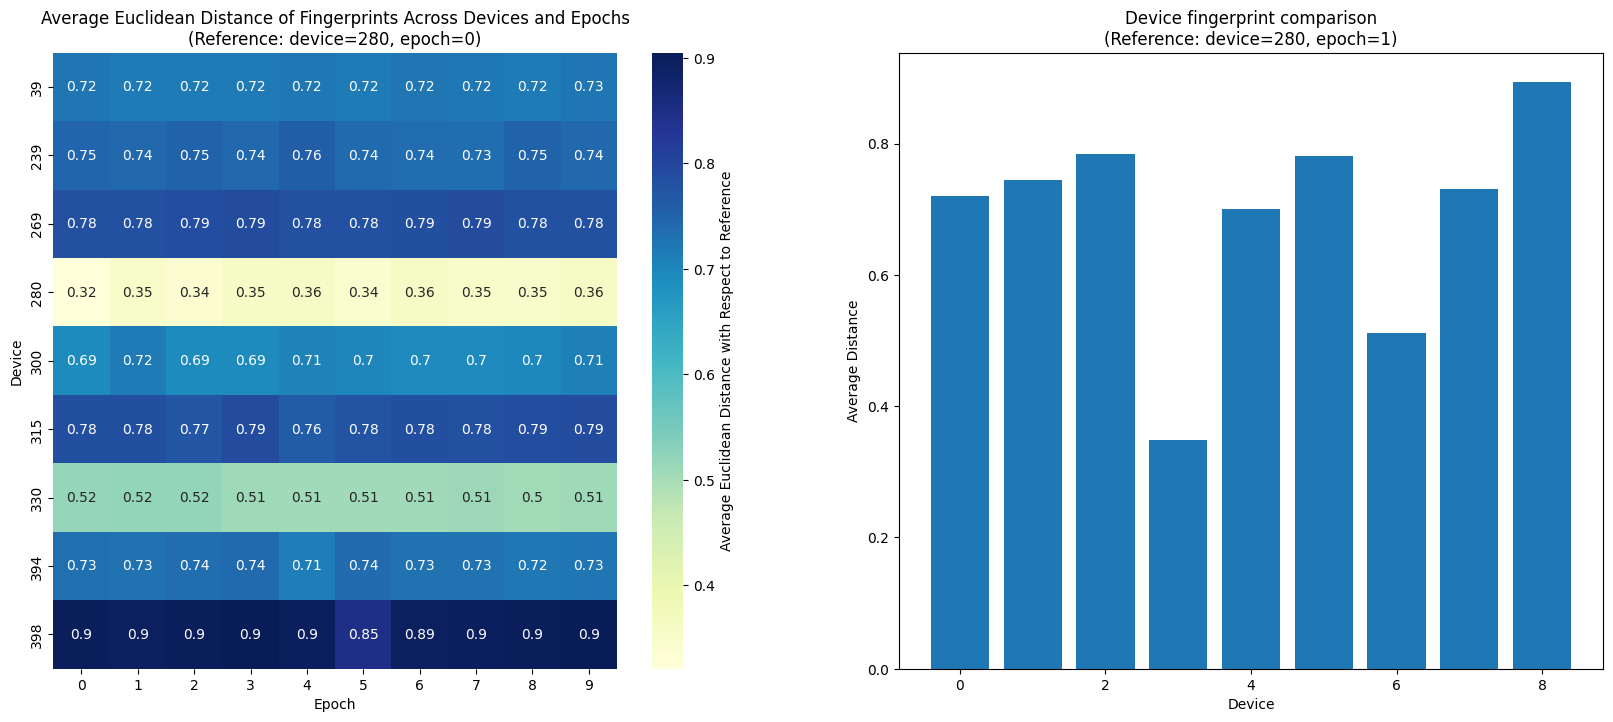

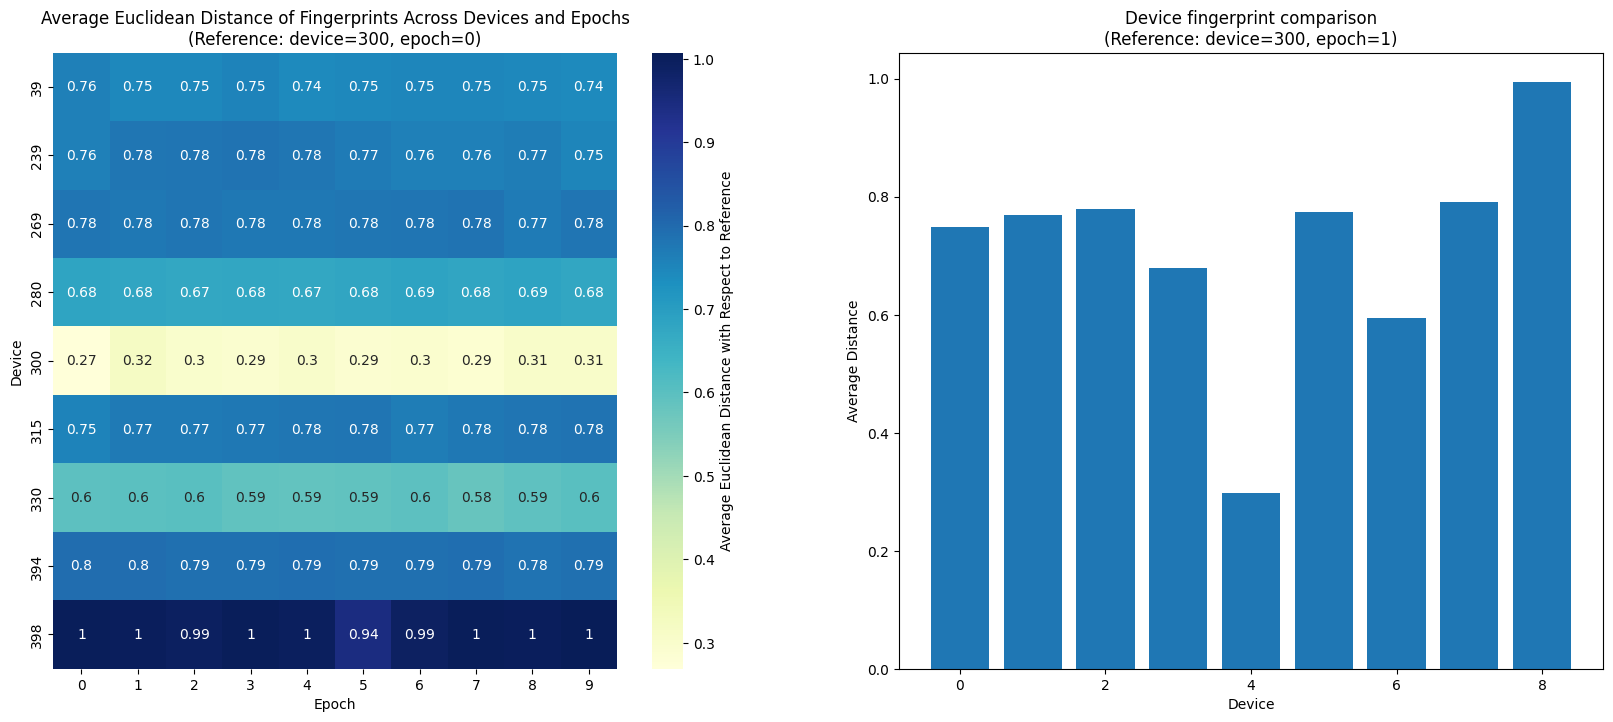

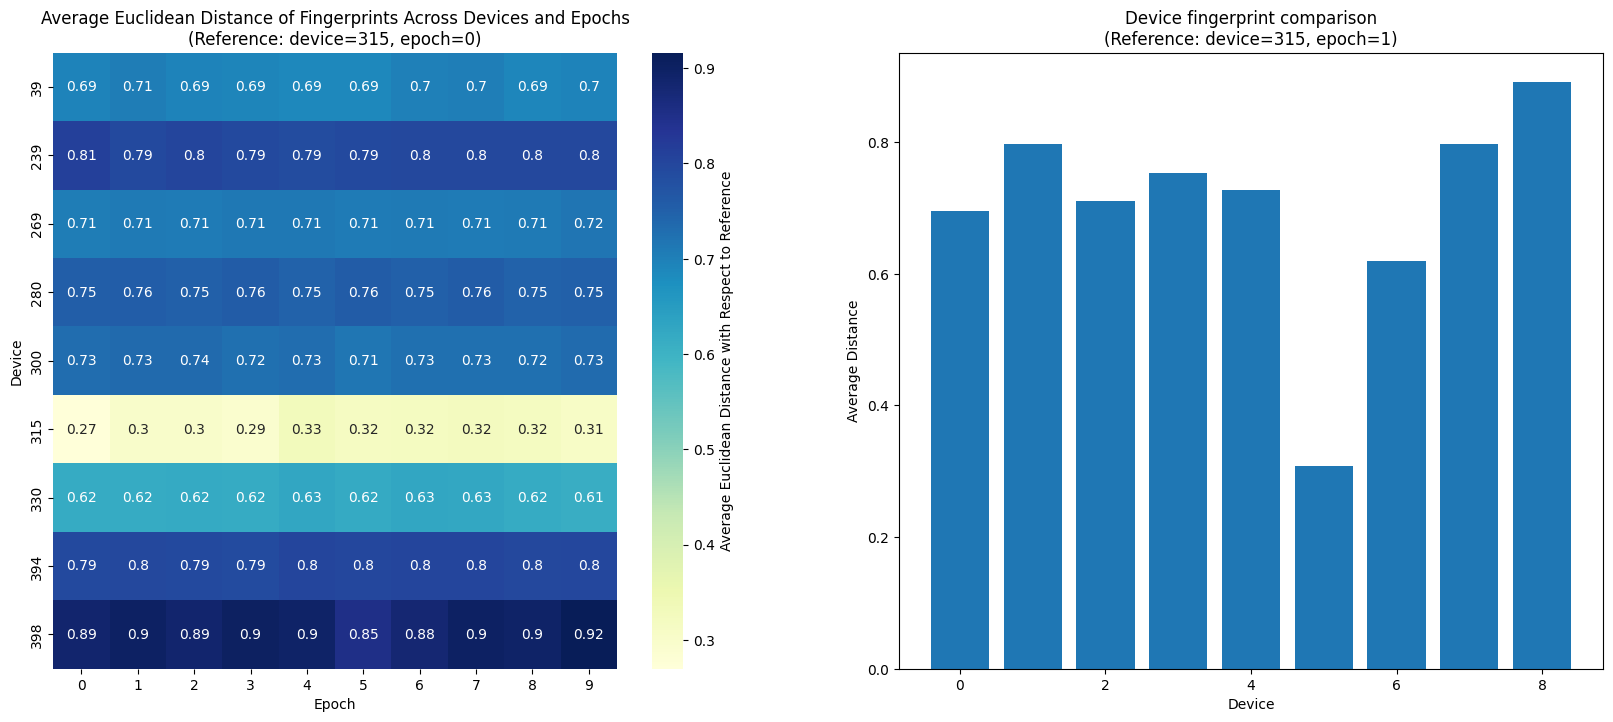

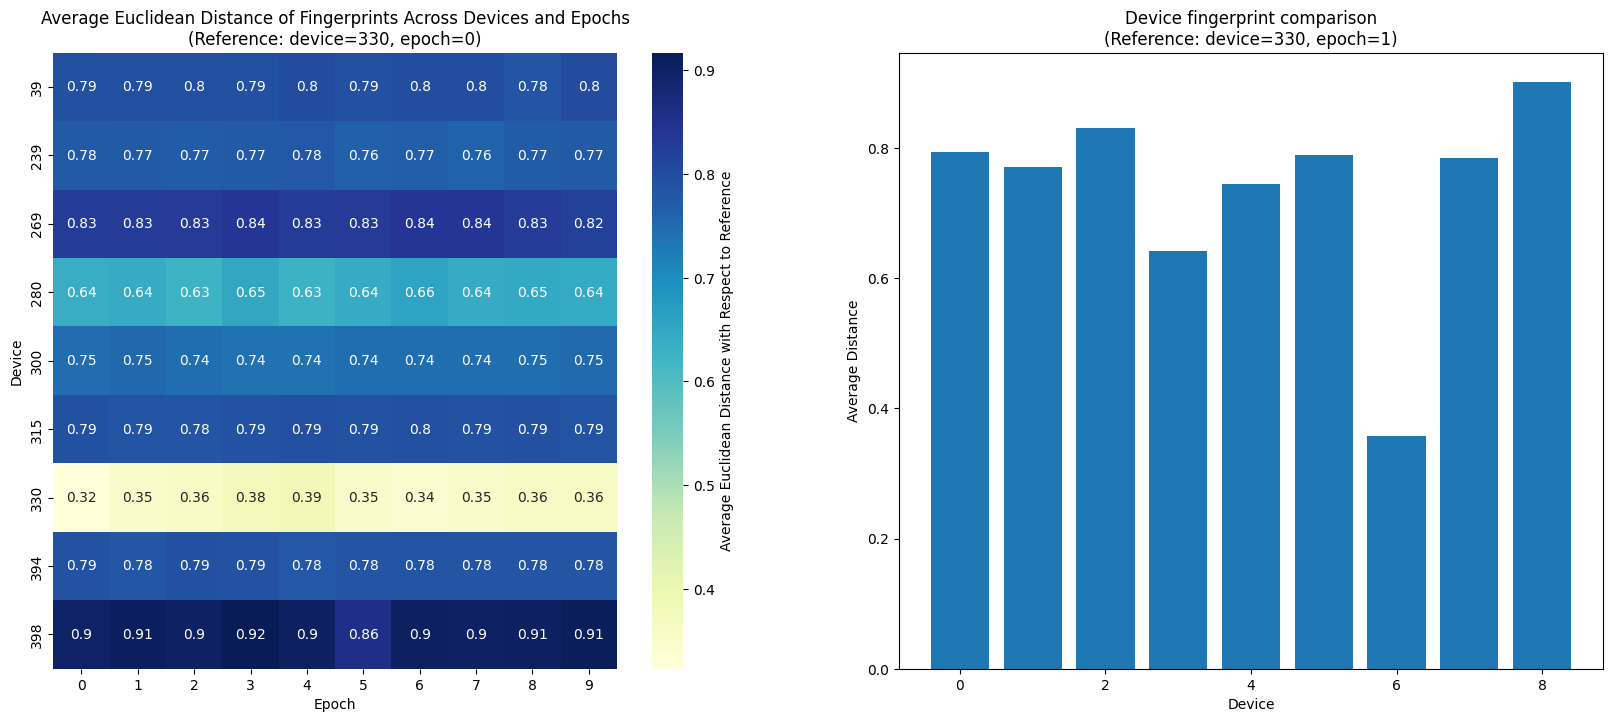

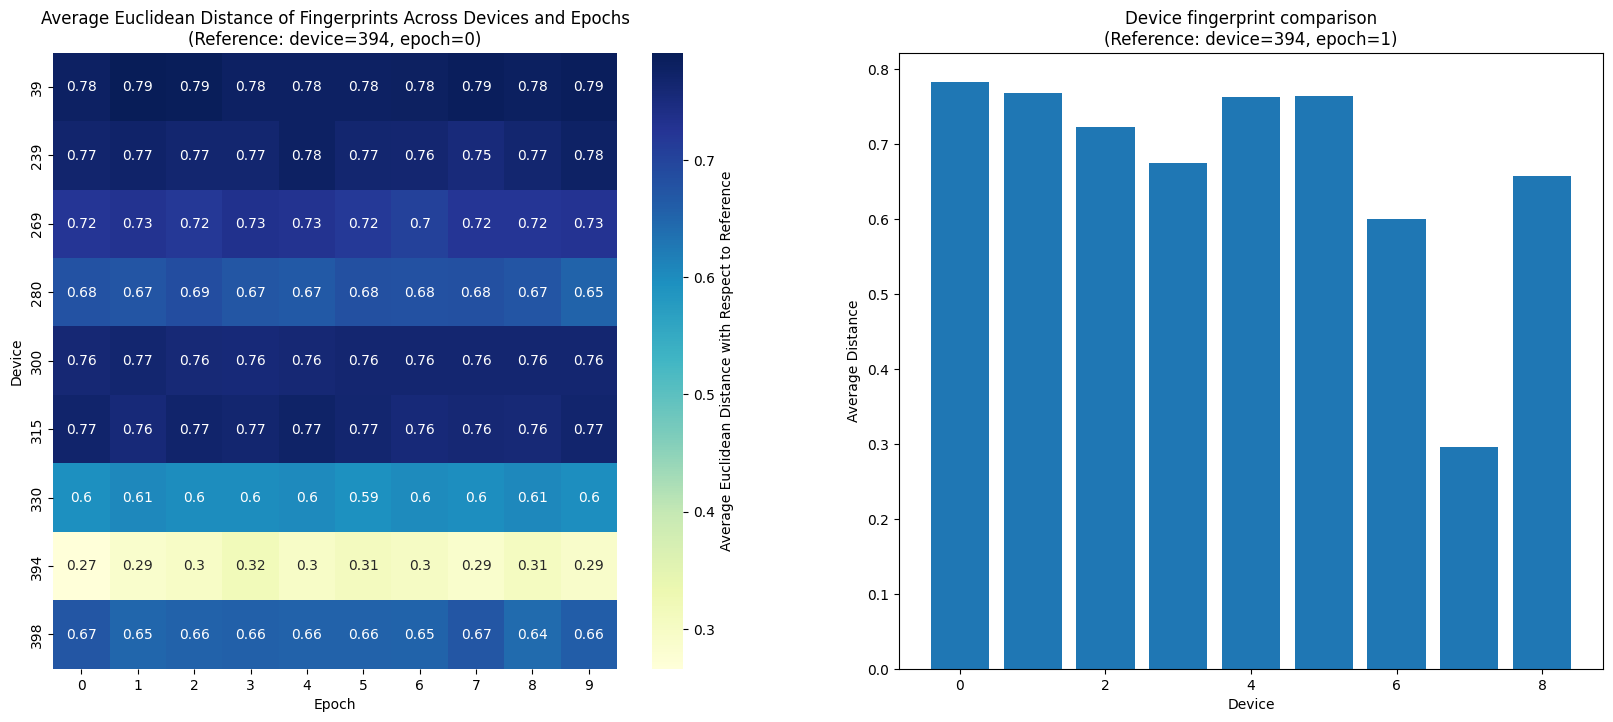

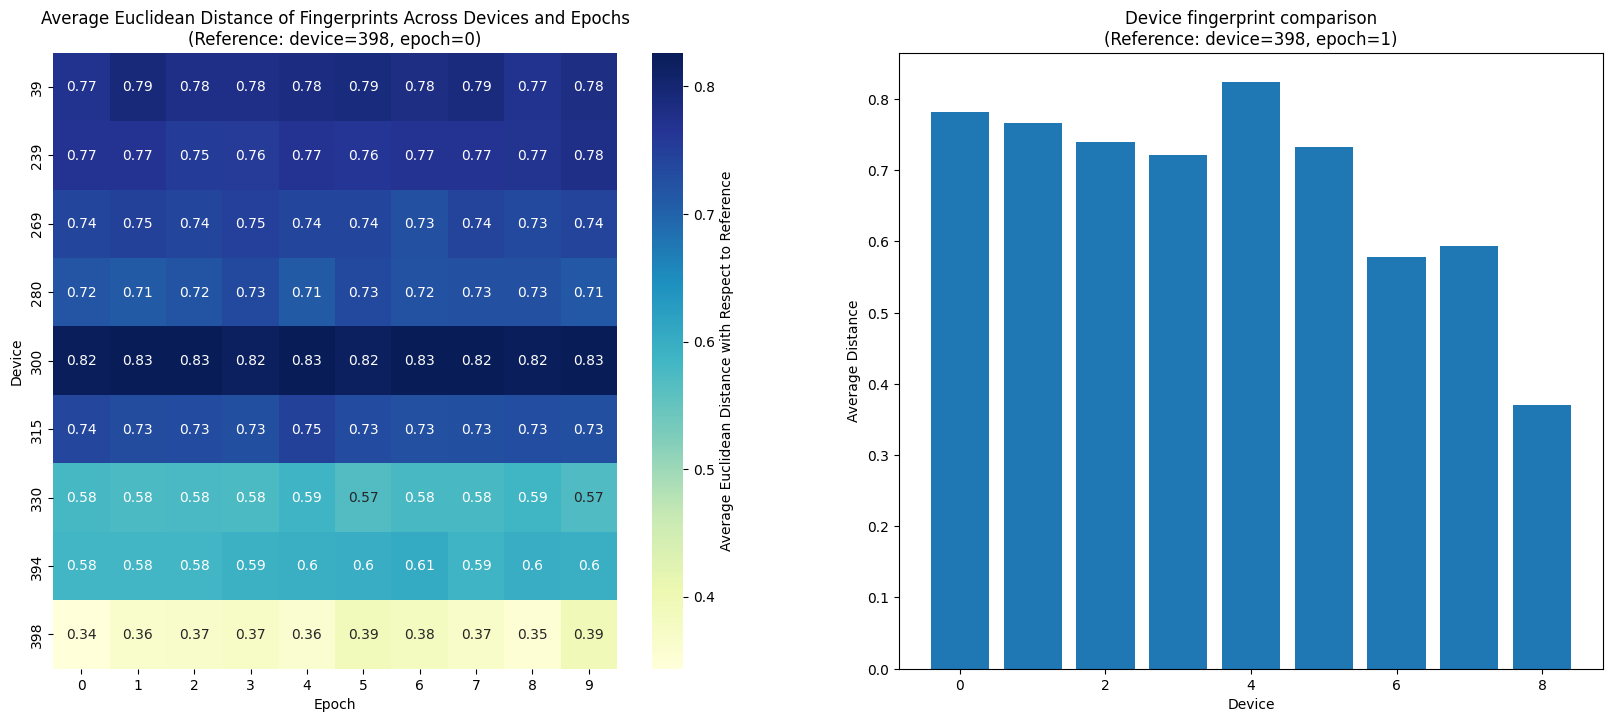

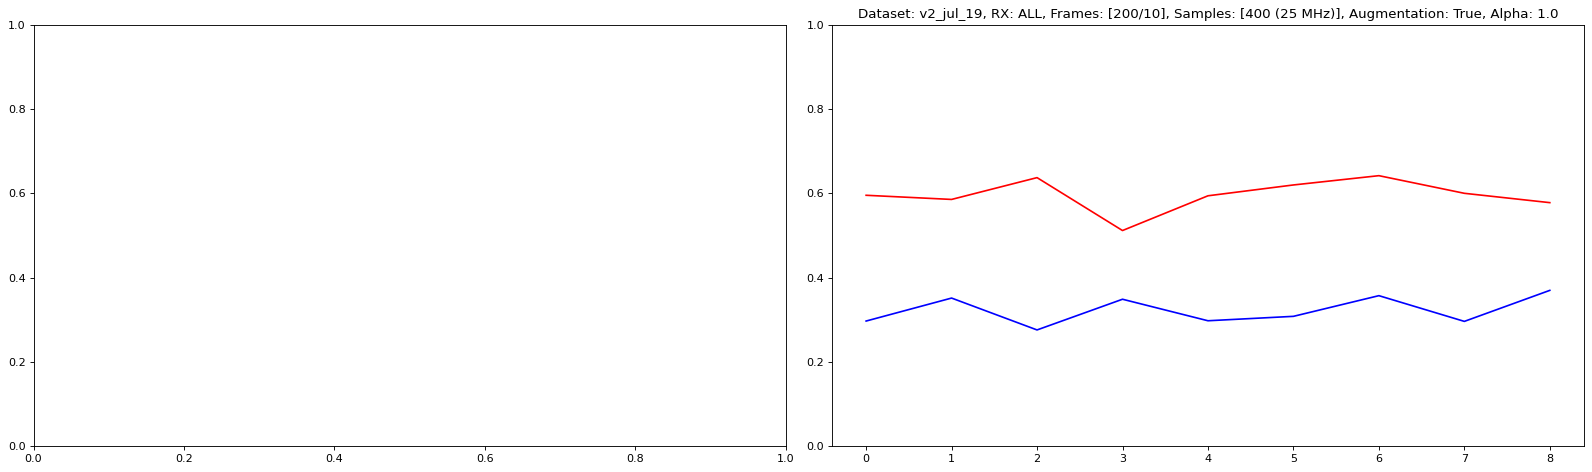

In [157]:
mateng = matlab.engine.connect_matlab('matlab_aug')
mateng.cd('/home/smazokha2016/Desktop/mobintel-rffi/fingerprinting/lora_rffi_working', nargout=0)

np.random.seed(1)

RX_NODES = ['node1-1', 'node1-20', 'node20-1', 'node19-19']
DATASETS = ['v1_jul_13', 'v2_jul_19', 'v2_jul_21']

try:
    aug_on = True
    show_fp_heatmaps = True
    show_training_history = True

    mult = 1

    experiment_configs = []
    for rx_node in RX_NODES:
        data_config = {
            'dataset_name': DATASETS[1],
            'rx_name': rx_node,
            'frame_count_train': 200,
            'frame_count_epoch': 10 * mult,
            'samples_count': 400 * mult,
            'merge_factor': mult
        }
        aug_config = {
            'multiplier': 5,
            't_rms_bounds': matlab.double([1, 2]),
            'd_f_bounds': matlab.double([0, 10]),
            'k_factor_bounds': matlab.double([0, 10]),
            'awgn': matlab.double([10, 50]),
        }
        model_config = {
            'batch_size': 32,
            # 'loss_type': 'triplet_loss', 'loss_num_neg': 1,
            'loss_type': 'quadruplet_loss', 'loss_num_neg': 2,
            #  'loss_type': 'quintuplet_loss', 'loss_num_neg': 3,
            # 'loss_type': 'n_loss', 'loss_num_neg': 2,
            'npair_type': 'samedev',
            # 'npair_type': 'diffdev',
            'alpha': 1.0, # used only for triple & quadruple loss
            'patience': 10,
            'fp_len': 512,
            'row': 50,
            'col': 14
        }
        experiment_configs.append((data_config, aug_config, model_config))

    # Dataset v2_jul19
    # node_ids_epoch_override=[1, 20, 39, 239, 269, 280, 300, 315, 330, 394, 398] # node1-1, node1-20
    # node_ids_epoch_override=[1, 10, 39, 239, 269, 280, 300, 315, 330, 394, 398] # node20-1
    node_ids_epoch_override=[39, 239, 269, 280, 300, 315, 330, 394, 398] # universally accepted

    # Dataset v2_jul21
    # node_ids_epoch_override = [39, 239, 269, 280, 300, 315, 394, 398]

    # models = []
    # histories = []
    # for experiment_config in experiment_configs:
    #     data_config, aug_config, model_config = experiment_config
        
    #     print(f"Training extractor for {data_config['rx_name']}...")
    #     model, history = run_training(mateng, data_config, model_config, aug_config, aug_on)

    #     models.append(model)
    #     histories.append(history)

    # model, history = run_training(mateng, data_config, model_config, aug_config, aug_on)
    # fp_distances, plot_title = run_fingerprinting(model, data_config, model_config, node_ids_epoch_override, aug_on, show_fp_heatmaps)
    fp_distances, plot_title = run_fingerprinting_all(RX_NODES, models, experiment_configs, node_ids_epoch_override, aug_on, show_fp_heatmaps)

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), dpi=80)

    # First subplot (model training history)
    # axs[0].plot(history.history['loss'])
    # axs[0].plot(history.history['val_loss'])
    # axs[0].set_title('Model loss')
    # axs[0].set_xlabel('Epoch')
    # axs[0].set_ylabel('Loss')
    # axs[0].legend(['Train', 'Validation'], loc='upper right')
    # axs[0].grid(True)
    # axs[0].set_title('Model training history')

    # Second subplot
    axs[1].plot(fp_distances[:, 0], color='blue', label="Top 1st Fingerprint Similarity")
    axs[1].plot(fp_distances[:, 1], color='red', label="Top 2nd Fingerprint Similarity")
    axs[1].set_ylim(0, 1)
    axs[1].set_title(plot_title)

    plt.tight_layout()
    plt.show()
finally:
    mateng.quit()

In [ ]:
def generate_node_ids():
    ids = {}
    coordinates = {}
    node_i = 0
    for i in np.arange(1, 21):
        for j in np.arange(1, 21):
            ids[str(i) + "-" + str(j)] = node_i
            node_i = node_i + 1
            coordinates[node_i] = (i, j)
    return ids, coordinates

def render_orbit_grid(tx_all, rx_all, tx_device):
    plt.figure(figsize=(8, 8), dpi=80)
    for i in np.arange(1, 21):
        for j in np.arange(1, 21):
            node = (i, j)

            plt.plot(i, j, '.', color='#D3D3D3')

            if node in tx_all:
                plt.plot(i, j, 'o', markerfacecolor='none', markeredgecolor='grey', markersize=8)

    for rx_device in rx_all:
        plt.plot(rx_device[0], rx_device[1], 'o', color='black', markersize=10)

    if tx_device:
        plt.plot(tx_device[0], tx_device[1], '.', color='red')
    plt.xticks(np.arange(2, 21, 2))
    plt.yticks(np.arange(2, 21, 2))
    ax = plt.gca()
    ax.invert_xaxis()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.show()

idx, coords = generate_node_ids()

# Note 20 is actually a receiving node. Don't use it.

tx_train_all = [coords[item] for item in [9, 11, 17, 25, 38, 52, 57, 60, 69, 70, 80, 84, 129, 133, 147, 157, 190, 203, 206, 216, 266, 360, 391, 399]]
tx_test_all = [coords[item] for item in [10, 39, 239, 269, 280, 300, 315, 330, 394, 398]]

render_orbit_grid(
    tx_all = tx_train_all + tx_test_all, 
    # rx_all = [(1, 1), (1, 20), (20, 1), (19, 19)], 
    rx_all = [(1, 1)],
    # tx_device = coords[39]) # 239
    # tx_device = coords[239])
    tx_device = coords[315])